# Artificial Neural Network

## About the algorithm

The artificial neural network (ANN) lies in the domain of deep learning field in contrast to the previous two algorithms which lie in the domain of machine learning. 

An artificial neural network is an interconnected group of nodes inspired by biological neural networks that constitute the brain. These algorithms were developed in the 1980s but saw a rise in adoption due to recent technological advancements in processing and storage capabilities. The network is said to consist of neurons which are mathematical functions also known as activation functions. The neurons are connected by edges that have certain weights i.e. the information is passed from one activation function to another in certain proportions. These weights change the basis on the training data and the corresponding errors. Thus, ANNs are said to be capable of changing their internal structure to find the relationship between dependent and independent variables.

In [30]:
# Import necessary packages
import pandas as pd
import numpy as np
import joblib
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 800
svg_renderer.height = 500
pio.renderers.default = "svg"

The procedure to train an ANN is similar to that of the precious algorithms.

## Model without oversample data

Considering data without oversampling,

In [2]:
# Load the data
df = pd.read_csv('./../../data/engineered_data.csv')

In [3]:
# Drop the index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Before modeling the data, the data is split into training and testing set.

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

There are hyperparamters which needs tuning in the ANN also. The following hyperparamters will be used for performing the grid search:

|Paramter|Description|Values|
|--|--|--|
|hiden_layer_sizes|Number of neuron each hidden layers which are comma-separated|$(100,), (64, 128, ), (128, 64, )$|
|activation|Activation to be used|1. 'logistic' for logistic activation <br> 2. 'tanh' for hyperbolic tangent activation <br> 3. 'relu' for rectified linear unit function|
|alpha|Paramter which determines the speed of training|$0.0001, 0.001, 0.01, 0.1$|
|max_iter|Maximum number of iterations|$200, 300, 400$|

In [5]:
# Declare the logistic regression model
ann_clf = MLPClassifier(solver='adam', learning_rate='adaptive', early_stopping=True)

# Declare the grid paramters to be searched
ann_params = dict(
    hidden_layer_sizes = [(100,), (64, 128, ), (128, 64, )],
    activation = ['logistic', 'tanh', 'relu'],
    alpha = [0.0001, 0.001, 0.01, 0.1],
    max_iter = [200, 300, 400],

)

In [ ]:
# Declare the gridsearch object
grid_search = GridSearchCV(ann_clf, ann_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train.values, y_train.values)

### Inferencing

The score and parameters for the best trained model are:

In [7]:
# Get the best model parameters
print(f"Best score of {grid_search.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.9571767300222584 is achieved by using {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (128, 64), 'max_iter': 400}


In [8]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test.values)
y_score = grid_search.predict_proba(X_test.values)[:, 1]

### Evaluation

AUC ROC with the best performing model

In [9]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9531468965157068


The AUC ROC of ANN is comparable to the SVM and is much better than the logistic regression alogrithm. But the amount of time required to train ANN is much smaller than the SVM algorithm and marginal greater than the logistic regression.

Usual procedure will be followed for finding the optimum threshold of classification.

In [10]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

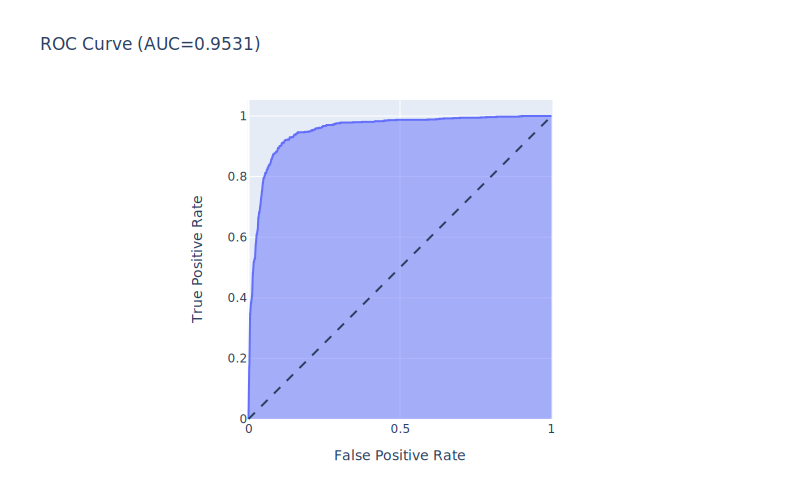

In [11]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [12]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

In [13]:
# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.79, 0.81)]

,fpr,tpr,threshold
170,0.049141,0.792474,0.647746
171,0.049618,0.792474,0.646578
172,0.049618,0.794755,0.645206
173,0.051050,0.794755,0.641181
174,0.051050,0.798176,0.636881
175,0.051527,0.798176,0.635136
176,0.051527,0.799316,0.633918
177,0.052004,0.799316,0.633026
178,0.052004,0.800456,0.631905
179,0.052481,0.800456,0.629496


The threshold for the optimum value of TPR is close to 0.64. Hence, the threshold that cen be used for classification will be 0.64. The final value can be decided after checking over the oversampled data.

In [15]:
# Save the model
joblib.dump(grid_result, './../../data/models/ann.pkl')

['./../../data/models/ann.pkl']

## Model with oversample data

Checking the model with the oversamples data.

In [16]:
# Load the data
df = pd.read_csv('./../../data/engineered_data_oversampled.csv')

In [17]:
# Drop the index column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

### Model Building

The parameters for training on the oversampled data is same as above.

In [19]:
# Declare the logistic regression model
ann_clf = MLPClassifier(solver='adam', learning_rate='adaptive', early_stopping=True)

# Declare the grid paramters to be searched
ann_params = dict(
    hidden_layer_sizes = [(100,), (64, 128, ), (128, 64, )],
    activation = ['logistic', 'tanh', 'relu'],
    alpha = [0.0001, 0.001, 0.01, 0.1],
    max_iter = [200, 300, 400]
)

In [ ]:
# Declare the gridsearch object
grid_search = GridSearchCV(ann_clf, ann_params, scoring='roc_auc', n_jobs=7, refit=True, cv=10, verbose=5)

# Fit the model
grid_result = grid_search.fit(X_train.values, y_train.values)

### Inferencing

Thus, the best model is represented by:

In [34]:
# Get the best model parameters
print(f"Best score of {grid_result.best_score_} is achieved by using {grid_result.best_params_}")

Best score of 0.9724049843047465 is achieved by using {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'max_iter': 300}


In [35]:
# Predict on test data using the model
y_pred = grid_search.predict(X_test)
y_score = grid_search.predict_proba(X_test)[:, 1]

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



### Evaluation

The AUC ROC is given by:

In [36]:
# Find the ROC AUC score
print(f"Area under the ROC curve: {roc_auc_score(y_test, y_score)}")

Area under the ROC curve: 0.9683070677874245


The AUC ROC of ANN with oversampled data is too high. It out-performed all the previous models.

The threshold values can be found with same previous procedures.

In [37]:
# Calculate parameters for roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

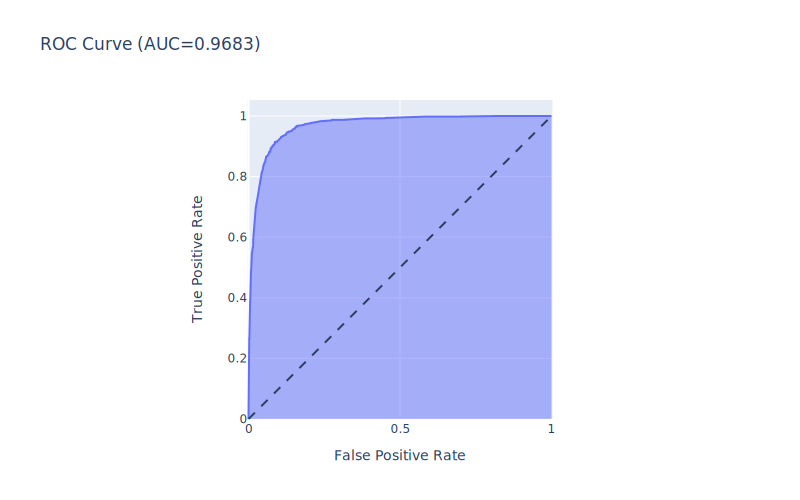

In [38]:
# Plot the curve and area under the curve
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate')
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [39]:
# Create a ROC dataframe from the obtained FPR and TPR
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

In [41]:
# Get the values of threshold for true positive rate between 0.79 and 0.81
roc_df[roc_df['tpr'].between(0.94, 0.95)]

,fpr,tpr,threshold
342,0.124221,0.942393,0.382804
343,0.124700,0.942393,0.382094
344,0.124700,0.943378,0.378682
345,0.125659,0.943378,0.376982
346,0.125659,0.944855,0.374228
347,0.126619,0.944855,0.373161
348,0.126619,0.945347,0.372686
349,0.127098,0.945347,0.372475
350,0.127098,0.945839,0.371995
351,0.130456,0.945839,0.365349


For this model, the threshold value can be set to 0.38.

In [43]:
# Compute the new classes based on the latest threshold
y_class = [1 if ys>0.38 else 0 for ys in y_score]

In [46]:
# Plot classification report
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      2085
         1.0       0.88      0.94      0.91      2031

    accuracy                           0.91      4116
   macro avg       0.91      0.91      0.91      4116
weighted avg       0.91      0.91      0.91      4116



The F1 score of 0.91 is remarkably high and is the best amongst all the models. Hence, it can be concluded that ANN is the best predictor for this data.

In [29]:
# Save the model
joblib.dump(grid_result, './../../data/models/ann_oversample.pkl')

['./../../data/models/ann_oversample.pkl']